In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.stats.diagnostic as diag
import scipy.stats as sc
from matplotlib import pyplot
import statsmodels.formula.api as smf

## FLOW:

This study focuses on the gasoline dataset and aims to work on deconstructing its components and try accurately predicting values. Different time series analysis techniques are conducted below. 

### Let's examine the gasoline supply data with time and take a subset of the data to work with:

In [2]:
gasoline = pd.read_csv("HW3_Data/gasoline.csv").iloc[:,1:]
gasoline.index = pd.date_range(start='02/02/1991', periods=1355, freq='W')

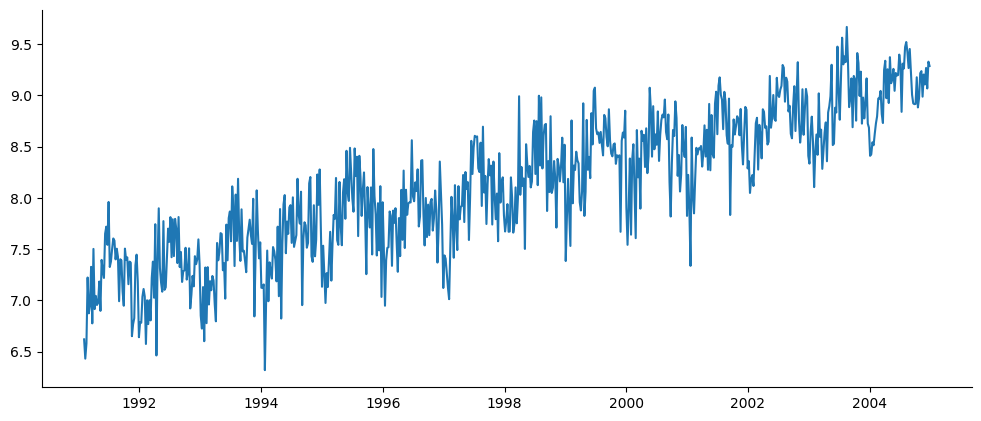

In [61]:
gasoline["Trend"] = np.arange(1,len(gasoline)+1)

gasoline_2004 = gasoline[gasoline.index<'01/01/2005']
gasoline_2005 = gasoline[gasoline.index>='01/01/2005']

plt.figure(figsize=(12,5), dpi=100)
plt.plot(gasoline_2004['x'], label='Data')
sns.despine()
plt.show()

### The dataset apperantly has a trend and let's start with fitting a Harmonic regression with trend:

In [19]:
gasoline_2004["Trend"] = np.arange(1,len(gasoline_2004)+1)

df1 = gasoline_2004.copy()
m=52
K = 2

for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

formula = "+".join(df1.columns[2:(len(df1.columns))])
formula="x~Trend+"+formula
mod2 = smf.ols(formula,data=df1)
res1 = mod2.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     688.8
Date:                Sun, 31 Jan 2021   Prob (F-statistic):          1.62e-271
Time:                        12:54:30   Log-Likelihood:                -115.83
No. Observations:                 726   AIC:                             243.7
Df Residuals:                     720   BIC:                             271.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0938      0.021    334.493      0.0

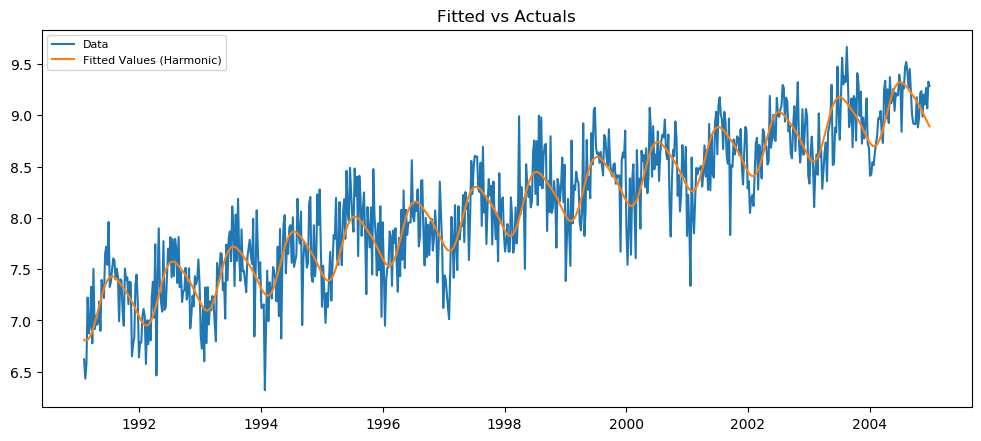

In [20]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df1['x'], label='Data')
plt.plot(res1.fittedvalues, label='Fitted Values (Harmonic)')
plt.title('Fitted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### Changing number of fourier terms:

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 31 Jan 2021   Prob (F-statistic):          3.51e-276
Time:                        12:55:22   Log-Likelihood:                -68.325
No. Observations:                 726   AIC:                             172.6
Df Residuals:                     708   BIC:                             255.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0946      0.020    354.075      0.0

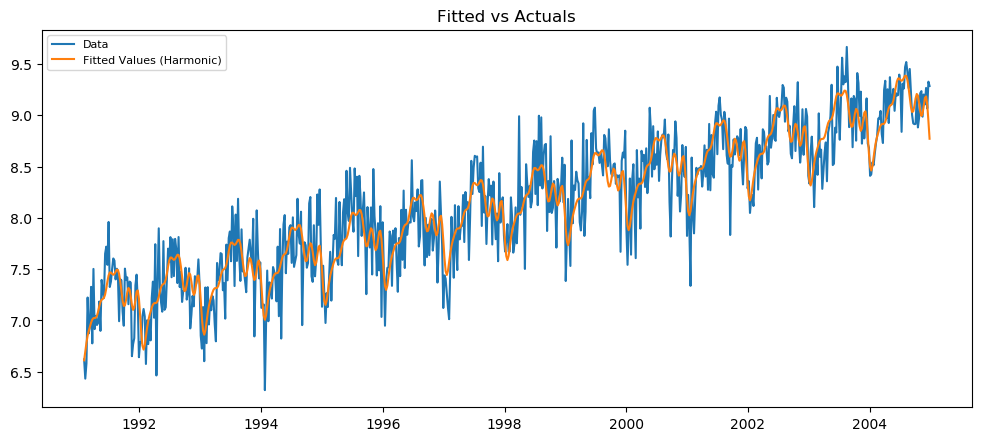

In [22]:
m=52
K = 8

for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

formula = "+".join(df1.columns[2:(len(df1.columns))])
formula="x~Trend+"+formula
mod2 = smf.ols(formula,data=df1)
res1 = mod2.fit()
print(res1.summary())

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df1['x'], label='Data')
plt.plot(res1.fittedvalues, label='Fitted Values (Harmonic)')
plt.title('Fitted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     121.6
Date:                Sun, 31 Jan 2021   Prob (F-statistic):          5.23e-263
Time:                        12:55:40   Log-Likelihood:                -57.127
No. Observations:                 726   AIC:                             182.3
Df Residuals:                     692   BIC:                             338.2
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0947      0.020    355.489      0.0

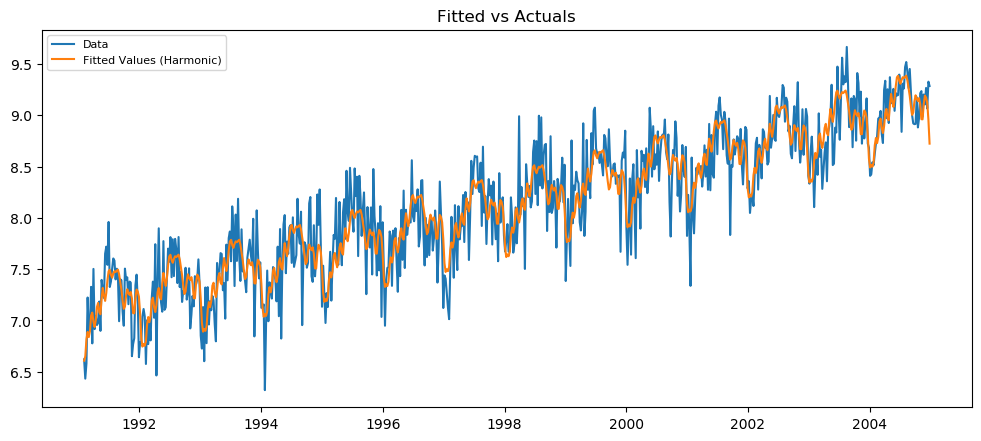

In [23]:
m=52
K = 16

for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

formula = "+".join(df1.columns[2:(len(df1.columns))])
formula="x~Trend+"+formula
mod2 = smf.ols(formula,data=df1)
res1 = mod2.fit()
print(res1.summary())

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df1['x'], label='Data')
plt.plot(res1.fittedvalues, label='Fitted Values (Harmonic)')
plt.title('Fitted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Let's check fourier terms within a loop and find the fourier terms that generate the AIC minimized model:

In [32]:
m=52

k_final = 9999
aic_final = 9999
for K in range(1,m+1):
    
    df1 = pd.DataFrame()
    df1["x"] = gasoline_2004["x"]
    df1["Trend"] = gasoline_2004["Trend"]
    
    for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
    for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

    formula = "+".join(df1.columns[2:(len(df1.columns))])
    formula="x~Trend+"+formula
    mod2 = smf.ols(formula,data=df1)
    res1 = mod2.fit()
    aic = res1.aic
    
    if aic_final > aic:
        aic_final = aic
        k_final = K

In [35]:
print("AIC Minimized model with number of fourier terms {} with AIC of {}".format(k_final,aic_final))

AIC Minimized model with number of fourier terms 7 with AIC of 170.08008367718685


##### AIC value is minimized with number of fourier terms of 7, lets define our function with 7 and follow the required procedures on that:

In [37]:
m=52
K=7

df1 = pd.DataFrame()
df1["x"] = gasoline_2004["x"]
df1["Trend"] = gasoline_2004["Trend"]

for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

formula = "+".join(df1.columns[2:(len(df1.columns))])
formula="x~Trend+"+formula
mod2 = smf.ols(formula,data=df1)
res1 = mod2.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      x   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     264.1
Date:                Sun, 31 Jan 2021   Prob (F-statistic):          2.66e-278
Time:                        13:16:44   Log-Likelihood:                -69.040
No. Observations:                 726   AIC:                             170.1
Df Residuals:                     710   BIC:                             243.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0947      0.020    354.233      0.000       7.055       7.134
Trend          0.0028   4.78e-05     58.591      0.000       0.003       0.003
Sin1          -0.0336      0.014     -2.376      0.018      -0.061      -0.006
Sin2          -0.0456      0.014     -3.235      0.001      -0.073      -0.018
Sin3          -0.0231      0.014     -1.638      0.102      -0.051       0.005
Sin4          -0.0024      0.014     -0.169      0.866      -0.030       0.025
Sin5          -0.0295      0.014     -2.090      0.037      -0.057      -0.002
Sin6          -0.0057      0.014     -0.403      0.687      -0.033       0.022
Sin7           0.0393      0.014      2.787      0.005       0.012       0.067
Cos1          -0.2677      0.014    -18.925      0.000      -0.295      -0.240
Cos2          -0.0073      0.014     -0.518      0.604      -0.035       0.020
Cos3          -0.0934      0.014     -6.607      0.000      -0.121      -0.066
Cos4          -0.0408      0.014     -2.882      0.004      -0.069      -0.013
Cos5          -0.0355      0.014     -2.508      0.012      -0.063      -0.008
Cos6          -0.0712      0.014     -5.033      0.000      -0.099      -0.043
Cos7          -0.0045      0.014     -0.319      0.749      -0.032       0.023
==============================================================================
Omnibus:                        1.857   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.721
Skew:                          -0.071   Prob(JB):                        0.423
Kurtosis:                       3.192   Cond. No.                         843.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  Residual Check:

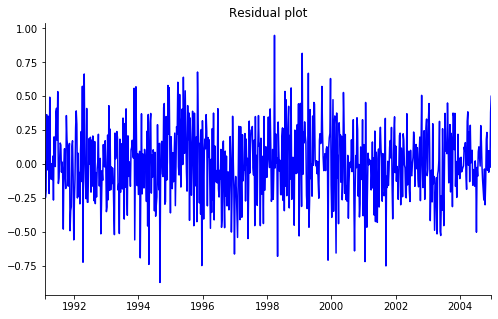

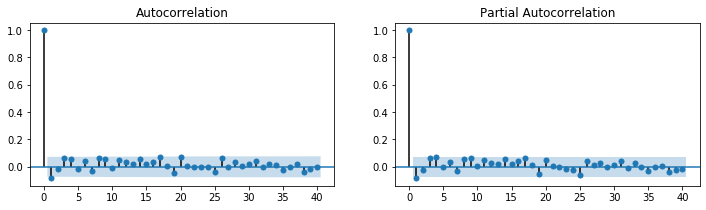

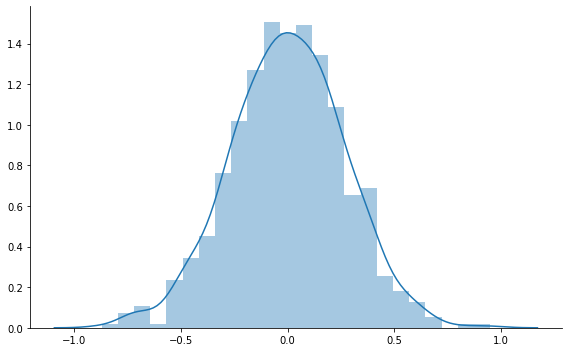

In [47]:
resid = df1["x"]-res1.fittedvalues

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,3))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])

fig, ax= plt.subplots(figsize=(8,5))
sns.distplot(resid, ax=ax)
sns.despine()

fig.tight_layout()
plt.show()

According to residual plots, our residuals are WN, and it is acceptable.
Moreover, residuals look like normally distributed.

### Forecasting with this model:

In [62]:
Xnew = gasoline_2005["2005"]
K = 7
m = 52
for i in range(K): Xnew['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*Xnew['Trend']/m)
for i in range(K): Xnew['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*Xnew['Trend']/m)
        

Xnew.drop('x', axis =  1, inplace = True)
Xnew = sm.add_constant(np.array(Xnew))

predictions = mod2.predict(res1.params, Xnew)
predictions

array([8.66267363, 8.61152271, 8.6375677 , 8.71666308, 8.81280095,
       8.89640897, 8.95462418, 8.99017747, 9.01282628, 9.03070444,
       9.04698928, 9.06215687, 9.07787454, 9.09816534, 9.12666969,
       9.16273275, 9.20041297, 9.23221629, 9.25523843, 9.27480467,
       9.30193582, 9.3454368 , 9.40388921, 9.46379856, 9.50642089,
       9.51962943, 9.50690145, 9.48648913, 9.4799813 , 9.49693289,
       9.52587892, 9.53889793, 9.50843456, 9.42660628, 9.31444926,
       9.21386308, 9.1655432 , 9.18544451, 9.25421231, 9.32688131,
       9.3580265 , 9.32785868, 9.25364797, 9.17929097, 9.1488433 ,
       9.17952718, 9.25016838, 9.31193508, 9.31516622, 9.23686412,
       9.09345838, 8.93238175])

### Plot Forecast vs Actual

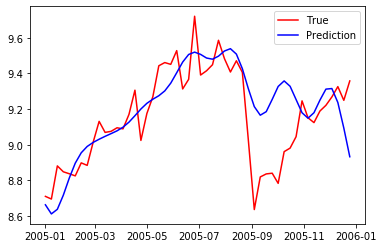

In [64]:
fig, ax = plt.subplots()
ax.plot(gasoline_2005['2005'].index, gasoline_2005['2005']['x'], 'b-', label="True", color = 'r')
ax.plot(gasoline_2005['2005'].index, predictions, 'b-', label="Prediction")
ax.legend(loc="best")

Our predictions are in line with actual values, however, they cannot capture rapid changes in the data.

## Now, let's study with the whole dataset rather than the subset, and include auto ARIMA Model to compare:

### Initial Procedure with the whole dataset:

In [91]:
m=52

k_final = 9999
aic_final = 9999
for K in range(1,m+1):
    
    df1 = pd.DataFrame()
    df1["x"] = gasoline["x"]
    df1["Trend"] = gasoline["Trend"]
    
    for i in range(K): df1['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*df1['Trend']/m)
    for i in range(K): df1['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*df1['Trend']/m)

    formula = "+".join(df1.columns[2:(len(df1.columns))])
    formula="x~Trend+"+formula
    mod2 = smf.ols(formula,data=df1)
    res1 = mod2.fit()
    aic = res1.aic
    
    if aic_final > aic:
        aic_final = aic
        k_final = K

In [92]:
print("AIC Minimized model with number of fourier terms {} with AIC of {}".format(k_final,aic_final))

AIC Minimized model with number of fourier terms 6 with AIC of 1518.1445051825922


### Auto Arima Trial:

In [93]:
K = 6
m=52
for i in range(K): gasoline['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*gasoline['Trend']/m)
for i in range(K): gasoline['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*gasoline['Trend']/m)
        
Xnew = gasoline.copy()
target = Xnew['x']
Xnew.drop('x', axis =  1, inplace = True)

ARIMA_auto=auto_arima(target,exogenous=np.array(Xnew),trend='c',seasonal=False)
ARIMA_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1355
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 -34.429
Date:                Sun, 31 Jan 2021   AIC                            106.858
Time:                        14:13:57   BIC                            205.877
Sample:                             0   HQIC                           143.934
                               - 1355                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0104      0.017      0.604      0.546      -0.023       0.044
x1             0.0014      0.001      1.894      0.058   -4.89e-05       0.003
x2            -0.0378      0.013     -2.842      0.004      -0.064      -0.012
x3            -0.0476      0.011     -4.505      0.000      -0.068      -0.027
x4            -0.0583      0.010     -5.844      0.000      -0.078      -0.039
x5            -0.0189      0.009     -2.023      0.043      -0.037      -0.001
x6            -0.0301      0.009     -3.169      0.002      -0.049      -0.011
x7            -0.0262      0.009     -2.843      0.004      -0.044      -0.008
x8            -0.2533      0.013    -19.383      0.000      -0.279      -0.228
x9             0.0135      0.010      1.315      0.189      -0.007       0.034
x10           -0.0691      0.010     -7.037      0.000      -0.088      -0.050
x11           -0.0388      0.010     -4.007      0.000      -0.058      -0.020
x12           -0.0063      0.009     -0.682      0.495      -0.025       0.012
x13           -0.0423      0.009     -4.525      0.000      -0.061      -0.024
ar.L1          0.9756      0.031     31.169      0.000       0.914       1.037
ar.L2          0.0430      0.035      1.228      0.219      -0.026       0.112
ar.L3         -0.0200      0.029     -0.690      0.490      -0.077       0.037
ma.L1         -0.8872      0.017    -51.539      0.000      -0.921      -0.853
sigma2         0.0622      0.002     28.621      0.000       0.058       0.066
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                24.17
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals: Looks like White Noise.

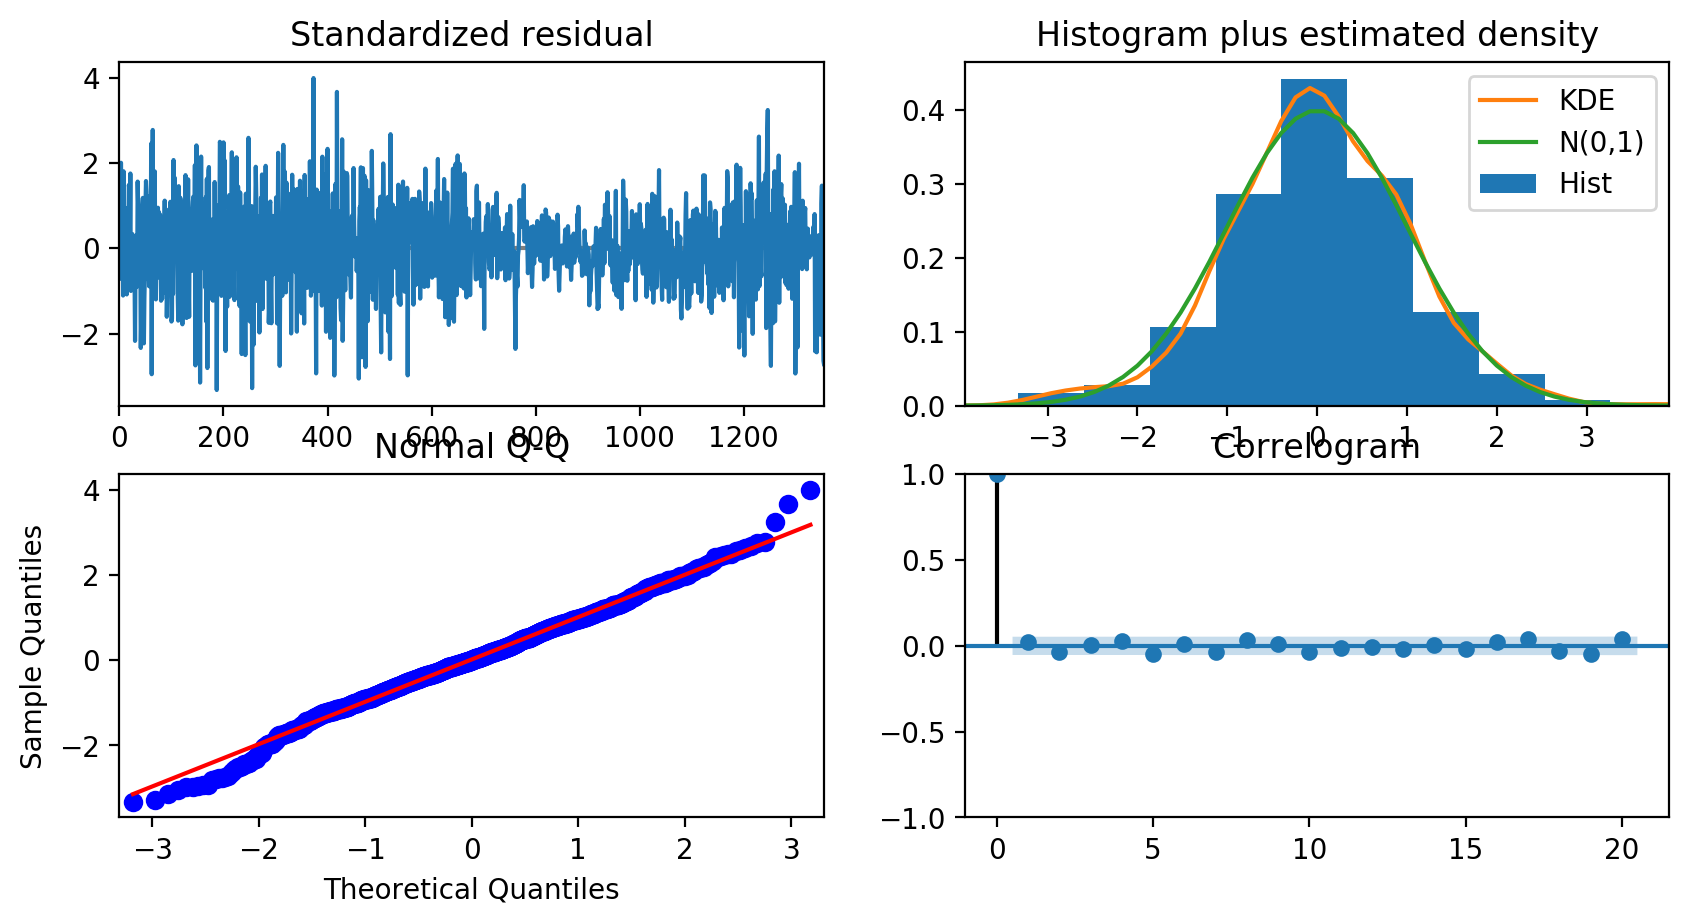

In [94]:
plot = ARIMA_auto.plot_diagnostics(lags=20,fig=plt.figure(figsize=(10,5), dpi=200))

### Forecasting:

Predictions:


array([8.71717787, 8.78648251, 8.86465499, 8.90243867, 8.91875941,
       8.92618127, 8.93883773, 8.96359199, 8.99800368, 9.03328444,
       9.06059437, 9.07691256, 9.08720587, 9.10175062, 9.13015899,
       9.17547513, 9.23168564, 9.28615584, 9.32583107, 9.34395294,
       9.34365344, 9.33634468, 9.3355355 , 9.34917505, 9.37454283,
       9.39854807, 9.403608  , 9.37639305, 9.31513406, 9.23173731,
       9.14742507, 9.08380963, 9.05362266, 9.05557492, 9.07584717,
       9.09546084, 9.09985594, 9.08588105, 9.06266536, 9.04589761,
       9.04838009, 9.07168896, 9.10335204, 9.12131639, 9.10388987,
       9.04055788, 8.93847679, 8.82135394, 8.72094191, 8.66482102,
       8.66586901])

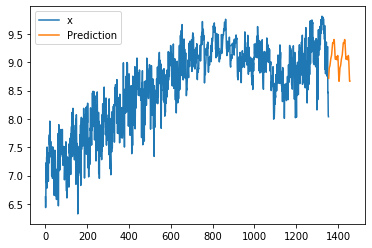

In [96]:
q1_pred = pd.DataFrame()
q1_pred['Trend'] =  np.arange(1356,1407)

K = 6
m=52

for i in range(K): q1_pred['Sin'+str(i+1)] = np.sin(2*(i+1)*np.pi*q1_pred['Trend']/m)
for i in range(K): q1_pred['Cos'+str(i+1)] = np.cos(2*(i+1)*np.pi*q1_pred['Trend']/m)
    
one_year_forecast = ARIMA_auto.predict(51, exogenous = np.array(q1_pred))

print('Predictions:')
display(one_year_forecast)

gasoline = gasoline.append(list(one_year_forecast), ignore_index = True)
gasoline['Prediction'] = gasoline[0]

gasoline[['x', 'Prediction']].plot()